In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings

from tqdm import tqdm

import umap

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

In [2]:
from dataset import *
from torchvision.transforms import Compose
transform=Compose([Reshape2DField(), ToTensor()])

tb_logs = '/project/vitelli/jonathan/REDO_fruitfly/tb_logs'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def agg_loader(loader):
    with torch.no_grad():
        params = []
        logvars = []
        y0s = []
        ys = []
        for batch in tqdm(loader):
            x, y0 = model.getxy(batch)
            y, pl = model(x.to(device))
            y0s.append(y0.cpu().numpy())
            ys.append(y.cpu().numpy())
            params.append(pl[0].cpu().numpy())
            logvars.append(pl[1].cpu().numpy())

        params = np.concatenate(params)
        logvars = np.concatenate(logvars)
        y0 = np.concatenate(y0s)
        y = np.concatenate(ys)
        return params, logvars, y0, y

# Variational Autoencoders and PCA

# Flow field

In [3]:
from translation_vae import TranslationVAE
beta=1e-2
output = 'vel'

checkpoint = torch.load(
    os.path.join(tb_logs,'TranslationVAE_%s_%s' % (output, output), 'beta=%g.ckpt' % beta))
print(checkpoint['hparams'])

model = TranslationVAE(**checkpoint['hparams'])
model.load_state_dict(checkpoint['state_dict'])
model.to(device)
model.eval()
vae = model.model

vel = AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform)
dataset = AlignedDataset([vel], ['vel'])

test_df = checkpoint['val_df']
test_df = pd.merge(dataset.df.reset_index(), test_df, how='inner', on=['embryoID', 'time'])
test_dataset = torch.utils.data.Subset(dataset, test_df['index'].values)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16,  shuffle=False)

train_df = pd.merge(dataset.df, test_df, indicator=True, how='outer', on=['embryoID', 'time'])
train_df = train_df[train_df['_merge'] == 'left_only']
train_dataset = torch.utils.data.Subset(dataset, train_df.index)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16,  shuffle=False)

params_train, logvars_train, y0_train, y_train = agg_loader(train_loader)
params_test, logvars_test, y0_test, y_test = agg_loader(test_loader)

"beta":         0.01
"in_channels":  2
"input":        vel
"input_size":   (236, 200)
"lr":           0.0001
"num_latent":   16
"out_channels": 2
"output":       vel
"stage_dims":   [[32, 32], [64, 64], [128, 128], [256, 256, 16]]
"weight_decay": 0.001


100%|██████████| 6/6 [00:00<00:00, 18.23it/s]


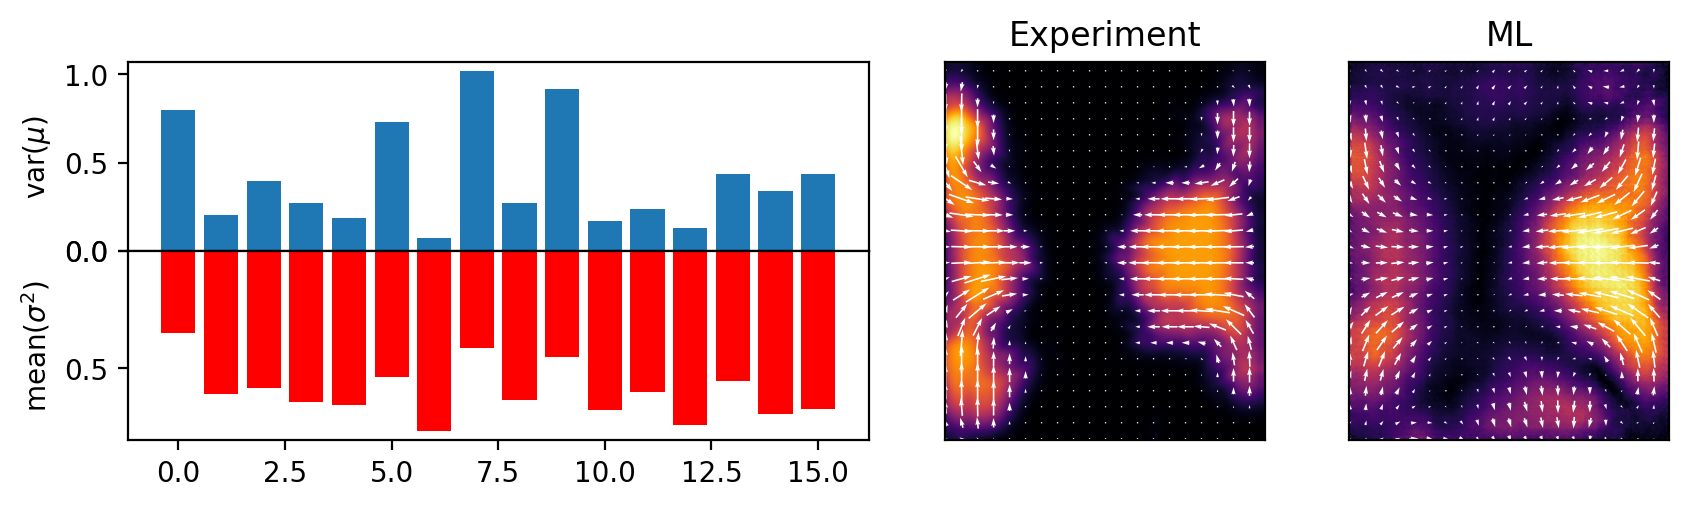

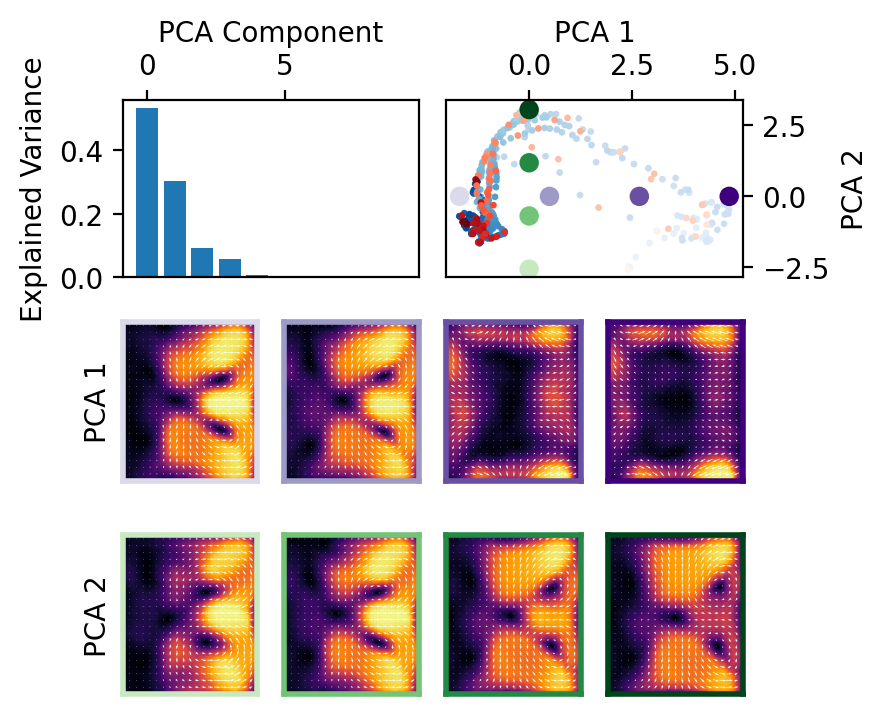

In [22]:
from plot_utils import *

def summary_plot(params, logvars, tt):
    param_id = np.arange(params.shape[-1])
    param_id = param_id[None].repeat(params.shape[0], axis=0)

    param_var = np.var(params, axis=0)
    var_mean = np.mean(np.exp(logvars), axis=0)

    fig = plt.figure(figsize=(10, 2.5), dpi=200)
    gs = fig.add_gridspec(2, 4)

    ax = fig.add_subplot(gs[0, :2])
    ax.bar(
        param_id[0],
        param_var)
    ax.set_ylabel('var($\mu$)')

    ax = fig.add_subplot(gs[1, :2])
    ax.bar(
        param_id[0],
        var_mean,
        color='red'
    )
    ax.invert_yaxis()
    ax.set_ylabel('mean($\sigma^2$)')

    plt.rcParams['image.origin'] = 'lower'
    plt.rcParams['image.cmap'] = 'inferno'
    plot_fn(fig.add_subplot(gs[:, -2]), y0_test[tt])
    plt.title('Experiment')
    plot_fn(fig.add_subplot(gs[:, -1]), y_test[tt])
    plt.title('ML')

    fig.subplots_adjust(hspace=0)
    
from sklearn.decomposition import PCA
import torch.nn.functional as F

def reconstruct_nn(z):
    with torch.no_grad():
        z = torch.cuda.FloatTensor(z)
        z = vae.params_to_field(z)
        z = F.gelu(z)
        z = z.reshape([z.shape[0], -1, *vae.bottleneck_size])
        z = vae.decoder(z)
        z = F.interpolate(z, size=[236, 200], mode='bilinear')
        z = z.cpu().numpy()
    return z

def sweep_points(reconstruct, pca, pca_points, fig, gs, ax, cmap, pca_axis):
    points = np.zeros([4, pca.n_components])
    points[:, pca_axis] = np.linspace(0, 1, points.shape[0]) * np.ptp(pca_points[:, pca_axis]) + np.min(pca_points[:, pca_axis])
    points[:, (pca_axis+1)%2] = 0

    z = pca.inverse_transform(points)
    z = reconstruct(z)

    colors = plt.get_cmap(cmap)(np.linspace(0, 1, points.shape[0]+1))[1:]    
    ax.scatter(points[:, 0], points[:, 1], color=colors)
    
    vmax = np.max(np.linalg.norm(z, axis=1))

    for i in range(len(colors)):
        a = fig.add_subplot(gs[pca_axis+1, i])
        plot_fn(a, z[i], vmax=vmax)
        for spine in a.spines.values():
            spine.set_edgecolor(colors[i])
            spine.set_linewidth(2)
        if i == 0:
            a.set_ylabel('PCA %d' % (pca_axis+1))

def pca_plot(train, test, reconstruct):
    n_components=10
    pca = PCA(n_components=n_components)

    pca_train = pca.fit_transform(train)
    pca_test = pca.transform(test)

    fig = plt.figure(figsize=(4, 4), dpi=200)
    gs = fig.add_gridspec(3, 4)

    ax = fig.add_subplot(gs[0, :2])
    ax.bar(np.arange(n_components), pca.explained_variance_ratio_)
    ax.set(xlabel='PCA Component', ylabel='Explained Variance')
    ax.xaxis.set_label_position("top")
    ax.xaxis.tick_top()

    ax = fig.add_subplot(gs[0, 2:])
    ax.scatter(pca_train[:, 0], pca_train[:, 1], c=train_df.time.values, cmap='Blues', s=2)
    ax.scatter(pca_test[:, 0], pca_test[:, 1], c=test_df.time.values, cmap='Reds', s=2)
    ax.set(xlabel='PCA 1', ylabel='PCA 2')
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.xaxis.set_label_position("top")
    ax.xaxis.tick_top()

    args = (reconstruct, pca, pca_train, fig, gs, ax)
    sweep_points(*args, pca_axis=0, cmap='Purples')
    sweep_points(*args, pca_axis=1, cmap='Greens')

plot_fn = plot_vector2D
params = np.concatenate([params_train, params_test])
logvars = np.concatenate([logvars_train, logvars_test])
summary_plot(params, logvars, 0)
pca_plot(params_train, params_test, reconstruct_nn)
#pca_plot(y0_train.reshape([y0_train.shape[0], -1]),
#         y0_test.reshape([y0_test.shape[0], -1]),
#         lambda x: x.reshape([-1, 2, 236, 200]))

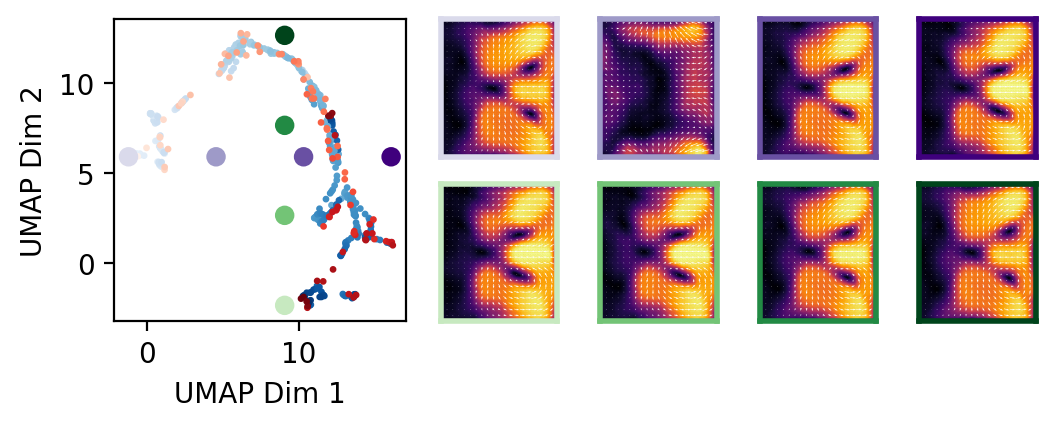

In [21]:
import torch.nn.functional as F

def reconstruct_nn(z):
    with torch.no_grad():
        z = torch.cuda.FloatTensor(z)
        z = vae.params_to_field(z)
        z = F.gelu(z)
        z = z.reshape([z.shape[0], -1, *vae.bottleneck_size])
        z = vae.decoder(z)
        z = F.interpolate(z, size=[236, 200], mode='bilinear')
        z = z.cpu().numpy()
    return z

def sweep_points_umap(reconstruct, umap, umap_points, fig, gs, ax, cmap, umap_axis):
    points = np.zeros([4, 2])
    points[:, umap_axis] = np.linspace(0, 1, points.shape[0]) * np.ptp(umap_points[:, umap_axis]) + np.min(umap_points[:, umap_axis])
    points[:, (umap_axis+1)%2] = np.mean(umap_points[:, (umap_axis+1)%2])

    z = umap.inverse_transform(points)
    z = reconstruct(z)

    colors = plt.get_cmap(cmap)(np.linspace(0, 1, points.shape[0]+1))[1:]    
    ax.scatter(points[:, 0], points[:, 1], color=colors)
    
    vmax = np.max(np.linalg.norm(z, axis=1))

    for i in range(len(colors)):
        a = fig.add_subplot(gs[umap_axis, i+2])
        plot_fn(a, z[i], vmax=vmax)
        for spine in a.spines.values():
            spine.set_edgecolor(colors[i])
            spine.set_linewidth(2)

import umap
def umap_plot(train, test, reconstruct):
    n_components=10
    U = umap.UMAP()

    umap_train = U.fit_transform(train)
    umap_test = U.transform(test)

    fig = plt.figure(figsize=(6, 2), dpi=200)
    gs = fig.add_gridspec(2, 6)

    ax = fig.add_subplot(gs[:, :2])
    ax.scatter(umap_train[:, 0], umap_train[:, 1], c=train_df.time.values, cmap='Blues', s=2)
    ax.scatter(umap_test[:, 0], umap_test[:, 1], c=test_df.time.values, cmap='Reds', s=2)
    ax.set(xlabel='UMAP Dim 1', ylabel='UMAP Dim 2')
    
    args = (reconstruct, U, umap_train, fig, gs, ax)
    sweep_points_umap(*args, umap_axis=0, cmap='Purples')
    sweep_points_umap(*args, umap_axis=1, cmap='Greens')
    
umap_plot(params_train, params_test, reconstruct_nn)

# Myosin field

100%|██████████| 6/6 [00:00<00:00, 13.54it/s]


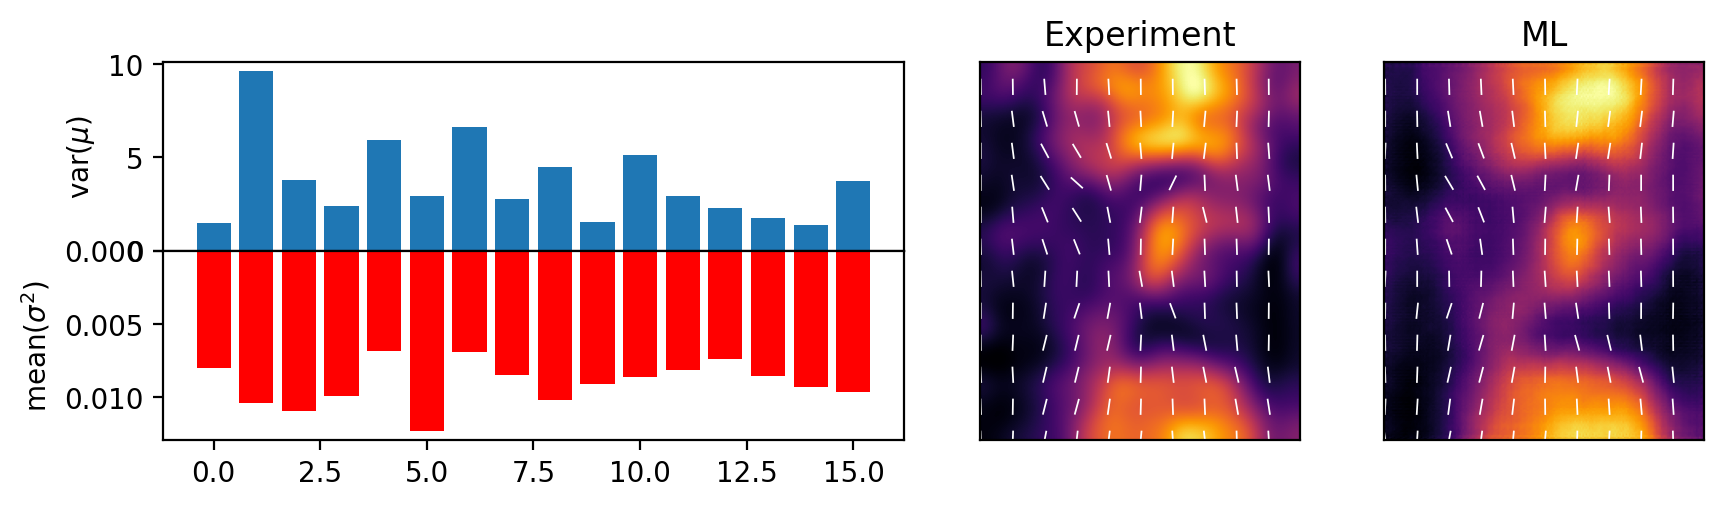

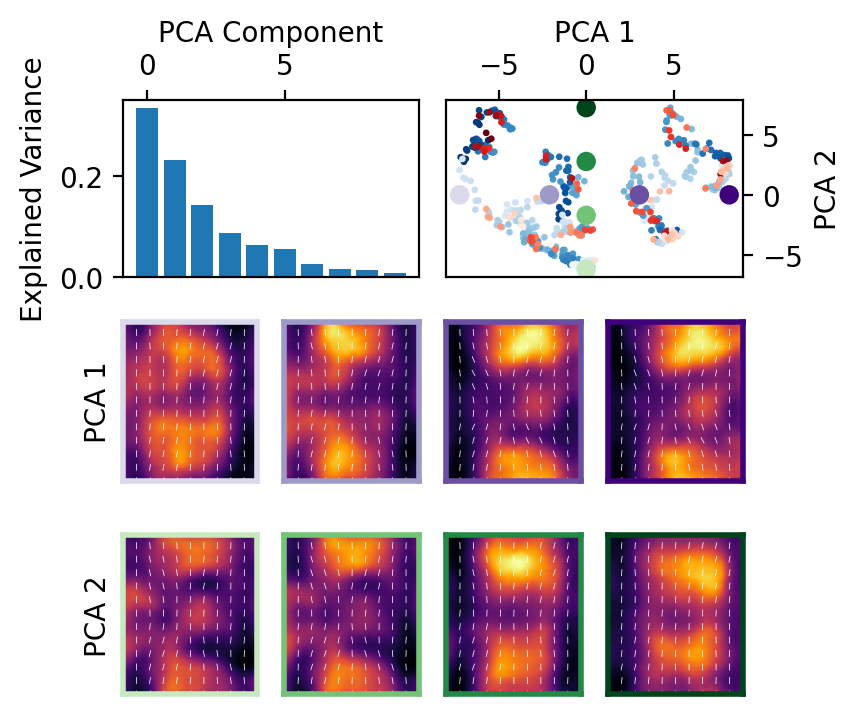

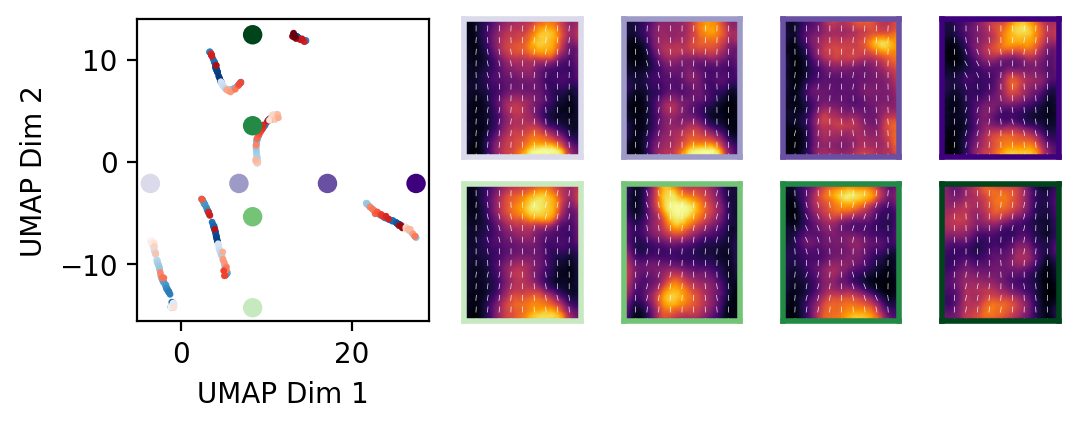

In [26]:
from translation_vae import TranslationVAE
beta=1e-5
output = 'sqh'

checkpoint = torch.load(
    os.path.join(tb_logs,'TranslationVAE_%s_%s' % (output, output), 'beta=%g.ckpt' % beta))

model = TranslationVAE(**checkpoint['hparams'])
model.load_state_dict(checkpoint['state_dict'])
model.to(device)
model.eval()
vae = model.model

vel = AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform)
sqh = AtlasDataset('WT', 'sqh-mCherry', 'tensor2D', transform=transform)

dataset = AlignedDataset([vel, sqh], ['vel', 'sqh'])

test_df = checkpoint['val_df']
test_df = pd.merge(dataset.df.reset_index(), test_df, how='inner', on=['embryoID', 'time'])
test_dataset = torch.utils.data.Subset(dataset, test_df['index'].values)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16,  shuffle=False)

train_df = pd.merge(dataset.df, test_df, indicator=True, how='outer', on=['embryoID', 'time'])
train_df = train_df[train_df['_merge'] == 'left_only']
train_dataset = torch.utils.data.Subset(dataset, train_df.index)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16,  shuffle=False)

params_train, logvars_train, y0_train, y_train = agg_loader(train_loader)
params_test, logvars_test, y0_test, y_test = agg_loader(test_loader)

plot_fn = plot_tensor2D
params = np.concatenate([params_train, params_test])
logvars = np.concatenate([logvars_train, logvars_test])
summary_plot(params, logvars, 25)
pca_plot(params_train, params_test, reconstruct_nn)
umap_plot(params_train, params_test, reconstruct_nn)

# Flow Autoencoders

0.01


[(0.0, 1.0)]

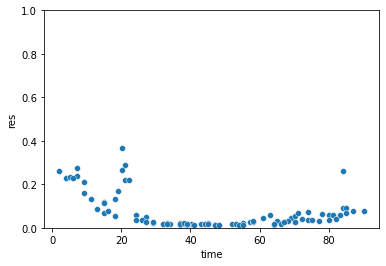

In [3]:
from translation_vae import TranslationVAE
version = 4
logdir = os.path.join('../tb_logs/TranslationVAE', 'version_%d' % version)
model = TranslationVAE.load_from_checkpoint(glob.glob(os.path.join(logdir, 'checkpoints', '*.ckpt'))[0])
model.eval()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(model.hparams['beta'])


test_df = pd.read_csv(os.path.join(logdir, 'test_df.csv'))
test_df = pd.merge(dataset.df.reset_index(), test_df, how='inner', on=['embryoID', 'time'])
test_dataset = torch.utils.data.Subset(dataset, test_df['index'].values)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16,  shuffle=False)

train_df = pd.merge(dataset.df, test_df, indicator=True, how='outer', on=['embryoID', 'time'])
train_df = train_df[train_df['_merge'] == 'left_only']
train_dataset = torch.utils.data.Subset(dataset, train_df.index)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16,  shuffle=False)

import seaborn as sns
ax = sns.scatterplot(
    data=test_df,
    x='time',
    y='res',
    legend=False,
)
ax.set(ylim=[0, 1])

In [4]:
def agg_loader(loader):
    with torch.no_grad():
        params = []
        logvars = []
        y0s = []
        ys = []
        for batch in tqdm(loader):
            x, y0 = model.getxy(batch)
            y, pl = model(x.to(device))
            y0s.append(y0.cpu().numpy())
            ys.append(y.cpu().numpy())
            params.append(pl[0].cpu().numpy())
            logvars.append(pl[1].cpu().numpy())

        params = np.concatenate(params)
        logvars = np.concatenate(logvars)
        y0 = np.concatenate(y0s)
        y = np.concatenate(ys)
        return params, logvars, y0, y

params_train, logvars_train, y0_train, y_train = agg_loader(train_loader)
params_test, logvars_test, y0_test, y_test = agg_loader(test_loader)

100%|██████████| 6/6 [00:00<00:00, 13.38it/s]


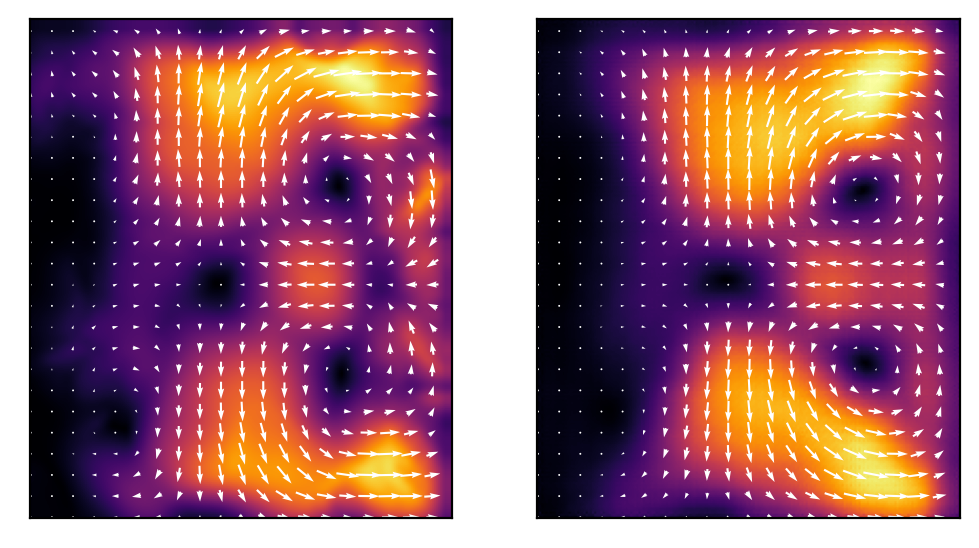

In [5]:
tt = 5
from plot_utils import *
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.cmap'] = 'inferno'
fig, ax = plt.subplots(1, 2, dpi=200)
plot_vector2D(ax[0], y0_test[tt])
plot_vector2D(ax[1], y_test[tt])

13.52445662908363
25.357562412793957


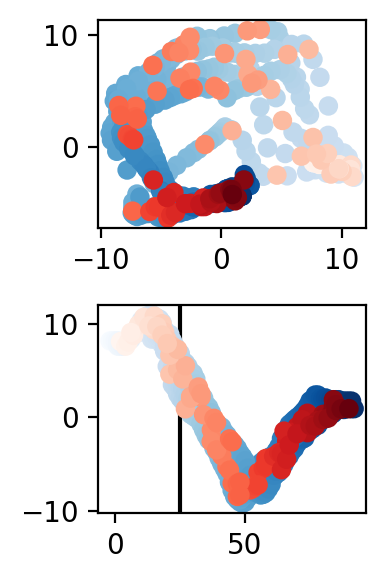

In [6]:
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams['image.origin'] = 'lower'

from sklearn import manifold

t = test_df.time.values
t = dataset.df.time.values
emb = manifold.Isomap(
    n_neighbors=12, 
    n_components=2
)
p_map_train = emb.fit_transform(params_train)
p_map_test = emb.transform(params_test)
print(emb.reconstruction_error())


fig = plt.figure(figsize=(8, 3), dpi=200)
gs = fig.add_gridspec(2, 5)

ax = fig.add_subplot(gs[0, 0])
ax.scatter(p_map_train[:, 0], p_map_train[:, 1], c=train_df.time.values, cmap='Blues')
ax.scatter(p_map_test[:, 0], p_map_test[:, 1], c=test_df.time.values, cmap='Reds')




emb = manifold.Isomap(
    n_neighbors=12, 
    n_components=1
)
p_map_train = emb.fit_transform(params_train)
p_map_test = emb.transform(params_test)
print(emb.reconstruction_error())

ax = fig.add_subplot(gs[1, 0])
ax.scatter(train_df.time.values, p_map_train, c=train_df.time.values, cmap='Blues')
ax.scatter(test_df.time.values, p_map_test, c=test_df.time.values, cmap='Reds')
ax.axvline(25, color='black', zorder=-1)
    
plt.tight_layout()

(375, 32)


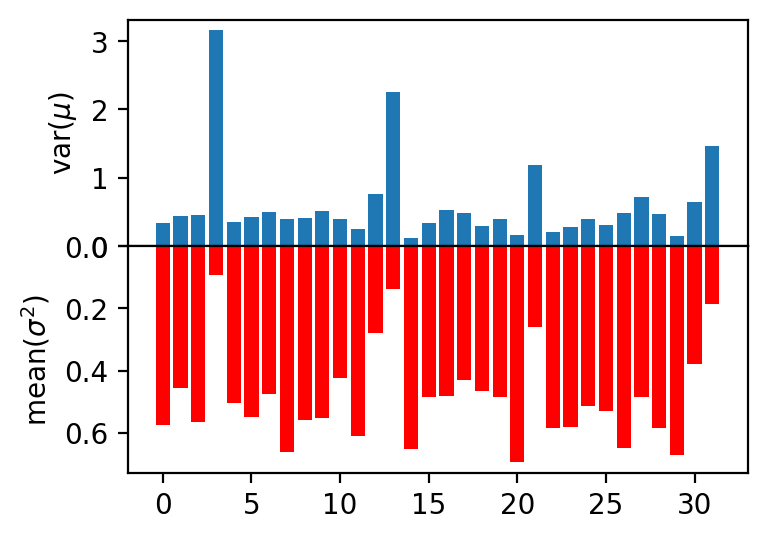

In [7]:
params = params_train
logvars = logvars_train

param_id = np.arange(params.shape[-1])
param_id = param_id[None].repeat(params.shape[0], axis=0)

param_var = np.var(params, axis=0)
var_mean = np.mean(np.exp(logvars), axis=0)

print(param_id.shape)

fig = plt.figure(figsize=(4, 3), dpi=200)
gs = fig.add_gridspec(2, 1)

ax = fig.add_subplot(gs[0, :])
ax.bar(
    param_id[0],
    param_var)
ax.set_ylabel('var($\mu$)')

ax = fig.add_subplot(gs[1, :])
ax.bar(
    param_id[0],
    var_mean,
    color='red'
)
ax.invert_yaxis()
ax.set_ylabel('mean($\sigma^2$)')

fig.subplots_adjust(hspace=0, wspace=1)

(4, 2, 236, 200)


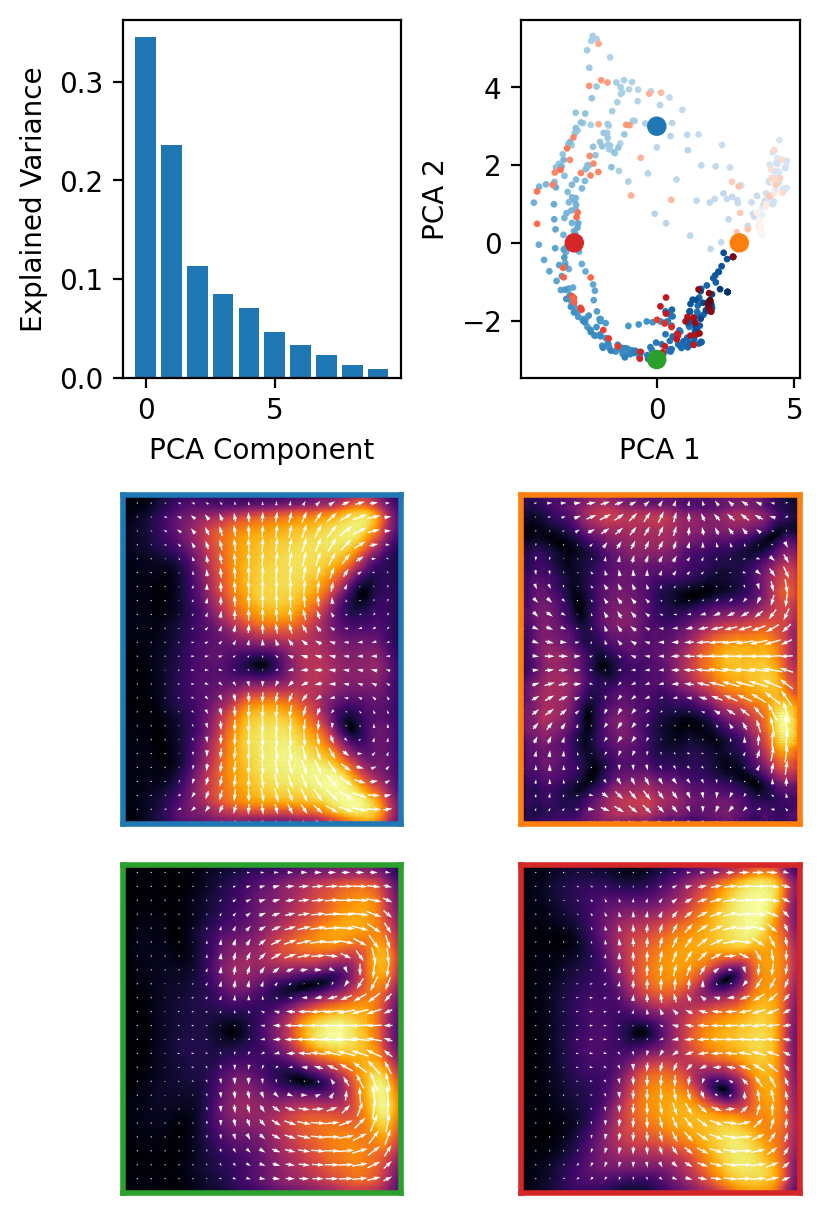

In [17]:
from sklearn.decomposition import PCA

n_components=10
pca = PCA(n_components=n_components)

pca_train = pca.fit_transform(params_train)
pca_test = pca.transform(params_test)

fig = plt.figure(figsize=(4, 6), dpi=200, constrained_layout=True)
gs = fig.add_gridspec(3, 4)

ax = fig.add_subplot(gs[0, :2])
ax.bar(np.arange(n_components), pca.explained_variance_ratio_)
ax.set(xlabel='PCA Component', ylabel='Explained Variance')

ax = fig.add_subplot(gs[0, 2:])
ax.scatter(pca_train[:, 0], pca_train[:, 1], c=train_df.time.values, cmap='Blues', s=2)
ax.scatter(pca_test[:, 0], pca_test[:, 1], c=test_df.time.values, cmap='Reds', s=2)
ax.set(xlabel='PCA 1', ylabel='PCA 2')


points = np.zeros([4, n_components])
points[:, :2] = np.array([[0, 3], [3, 0], [0, -3], [-3, 0]])

import torch.nn.functional as F
vae = model.model
with torch.no_grad():
    z = torch.cuda.FloatTensor(pca.inverse_transform(points[:, None]))
    z = vae.params_to_field(z)
    z = F.gelu(z)
    z = z.reshape([z.shape[0], -1, *vae.bottleneck_size])
    z = vae.decoder(z)
    z = F.interpolate(z, size=[236, 200], mode='bilinear')
    z = z.cpu().numpy()
    print(z.shape)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:points.shape[0]]
ax.scatter(points[:, 0], points[:, 1], color=colors)

axes = [
    fig.add_subplot(gs[1, :2]),
    fig.add_subplot(gs[1, 2:]),
    fig.add_subplot(gs[2, :2]),
    fig.add_subplot(gs[2, 2:])
]

for i in range(len(points)):
    a = axes[i]
    plot_vector2D(a, z[i])
    for spine in a.spines.values():
        spine.set_edgecolor(colors[i])
        spine.set_linewidth(2)


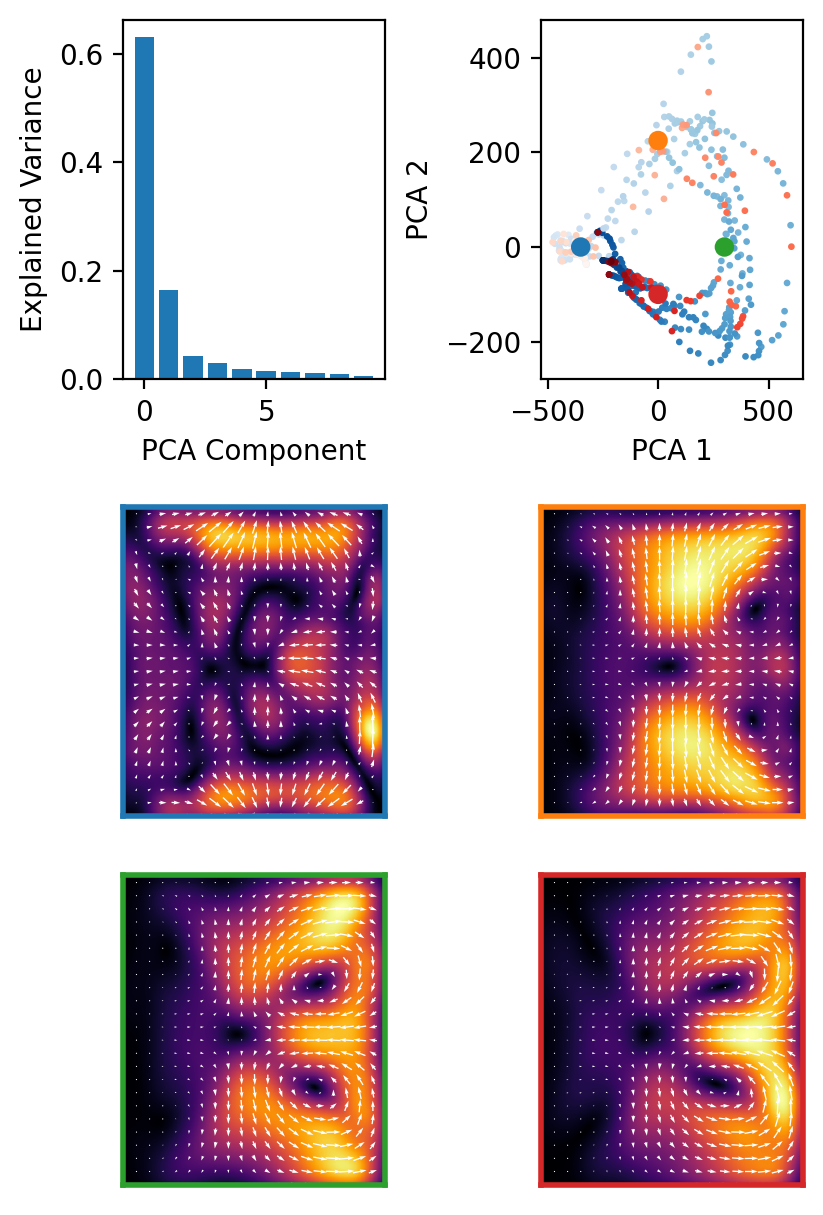

In [15]:
from sklearn.decomposition import PCA

n_components=10
pca = PCA(n_components=n_components)

pca_train = pca.fit_transform(y0_train.reshape([y0_train.shape[0], -1]))
pca_test = pca.transform(y0_test.reshape([y0_test.shape[0], -1]))

fig = plt.figure(figsize=(4, 6), dpi=200, constrained_layout=True)
gs = fig.add_gridspec(3, 4)

ax = fig.add_subplot(gs[0, :2])
ax.bar(np.arange(n_components), pca.explained_variance_ratio_)
ax.set(xlabel='PCA Component', ylabel='Explained Variance')

ax = fig.add_subplot(gs[0, 2:])
ax.scatter(pca_train[:, 0], pca_train[:, 1], c=train_df.time.values, cmap='Blues', s=2)
ax.scatter(pca_test[:, 0], pca_test[:, 1], c=test_df.time.values, cmap='Reds', s=2)
ax.set(xlabel='PCA 1', ylabel='PCA 2')


points = np.zeros([4, n_components])
points[:, :2] = np.array([[-350, 0], [0, 225], [300, 0], [0, -100]])

z = pca.inverse_transform(points).reshape([-1, 2, 236, 200])

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:points.shape[0]]
ax.scatter(points[:, 0], points[:, 1], color=colors)

axes = [
    fig.add_subplot(gs[1, :2]),
    fig.add_subplot(gs[1, 2:]),
    fig.add_subplot(gs[2, :2]),
    fig.add_subplot(gs[2, 2:])
]

for i in range(len(points)):
    a = axes[i]
    plot_vector2D(a, z[i])
    for spine in a.spines.values():
        spine.set_edgecolor(colors[i])
        spine.set_linewidth(2)


# Myosin Autoencoders

0.0001


[(0.0, 1.0)]

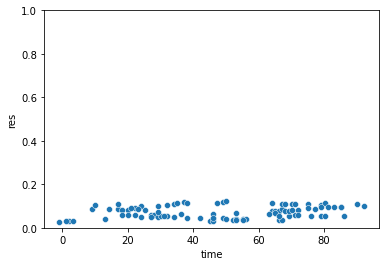

In [21]:
from translation_vae import TranslationVAE
version = 14
logdir = os.path.join('../tb_logs/TranslationVAE', 'version_%d' % version)
model = TranslationVAE.load_from_checkpoint(glob.glob(os.path.join(logdir, 'checkpoints', '*.ckpt'))[0])
model.eval()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(model.hparams['beta'])


test_df = pd.read_csv(os.path.join(logdir, 'test_df.csv'))
test_df = pd.merge(dataset.df.reset_index(), test_df, how='inner', on=['embryoID', 'time'])
test_dataset = torch.utils.data.Subset(dataset, test_df['index'].values)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16,  shuffle=False)

train_df = pd.merge(dataset.df, test_df, indicator=True, how='outer', on=['embryoID', 'time'])
train_df = train_df[train_df['_merge'] == 'left_only']
train_dataset = torch.utils.data.Subset(dataset, train_df.index)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16,  shuffle=False)

import seaborn as sns
ax = sns.scatterplot(
    data=test_df,
    x='time',
    y='res',
    legend=False,
)
ax.set(ylim=[0, 1])

In [22]:
def agg_loader(loader):
    with torch.no_grad():
        params = []
        logvars = []
        y0s = []
        ys = []
        for batch in tqdm(loader):
            x, y0 = model.getxy(batch)
            y, pl = model(x.to(device))
            y0s.append(y0.cpu().numpy())
            ys.append(y.cpu().numpy())
            params.append(pl[0].cpu().numpy())
            logvars.append(pl[1].cpu().numpy())

        params = np.concatenate(params)
        logvars = np.concatenate(logvars)
        y0 = np.concatenate(y0s)
        y = np.concatenate(ys)
        return params, logvars, y0, y

params_train, logvars_train, y0_train, y_train = agg_loader(train_loader)
params_test, logvars_test, y0_test, y_test = agg_loader(test_loader)

100%|██████████| 6/6 [00:00<00:00, 15.94it/s]


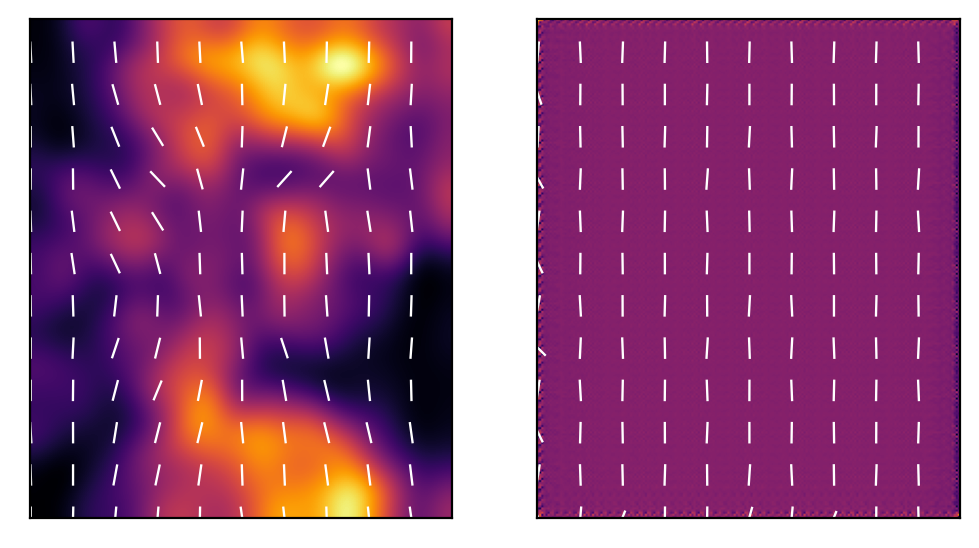

In [39]:
tt = 25
from plot_utils import *
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.cmap'] = 'inferno'
fig, ax = plt.subplots(1, 2, dpi=200)
plot_tensor2D(ax[0], y0_test[tt])
plot_tensor2D(ax[1], y_test[tt])

(375, 16)


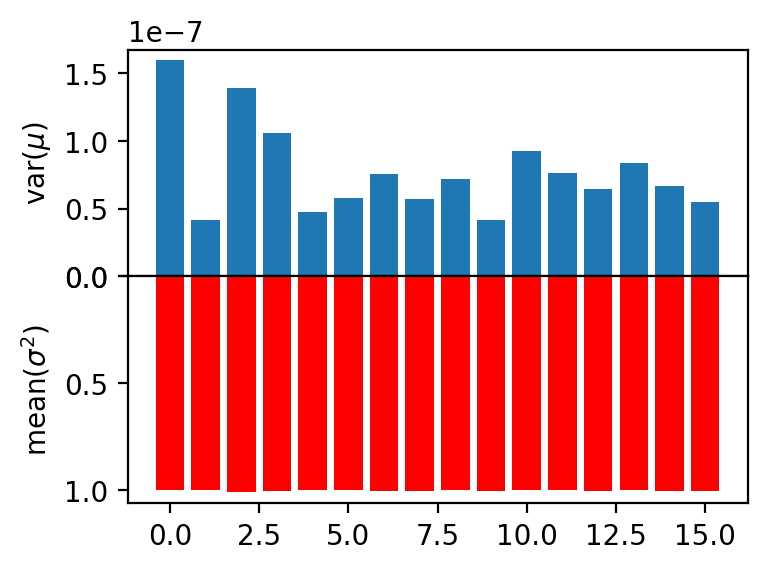

In [25]:
params = params_train
logvars = logvars_train

param_id = np.arange(params.shape[-1])
param_id = param_id[None].repeat(params.shape[0], axis=0)

param_var = np.var(params, axis=0)
var_mean = np.mean(np.exp(logvars), axis=0)

print(param_id.shape)

fig = plt.figure(figsize=(4, 3), dpi=200)
gs = fig.add_gridspec(2, 1)

ax = fig.add_subplot(gs[0, :])
ax.bar(
    param_id[0],
    param_var)
ax.set_ylabel('var($\mu$)')

ax = fig.add_subplot(gs[1, :])
ax.bar(
    param_id[0],
    var_mean,
    color='red'
)
ax.invert_yaxis()
ax.set_ylabel('mean($\sigma^2$)')

fig.subplots_adjust(hspace=0, wspace=1)

(4, 4, 236, 200)


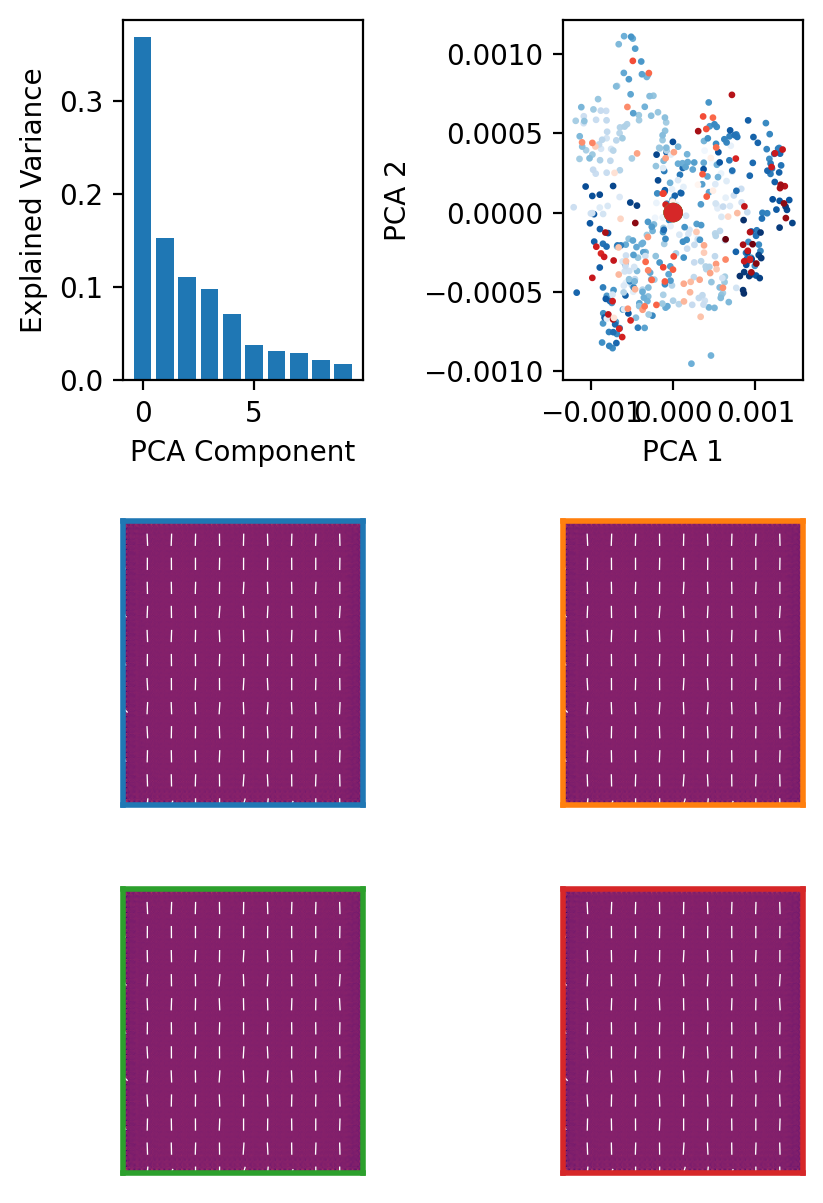

In [29]:
from sklearn.decomposition import PCA

n_components=10
pca = PCA(n_components=n_components)

pca_train = pca.fit_transform(params_train)
pca_test = pca.transform(params_test)

fig = plt.figure(figsize=(4, 6), dpi=200, constrained_layout=True)
gs = fig.add_gridspec(3, 4)

ax = fig.add_subplot(gs[0, :2])
ax.bar(np.arange(n_components), pca.explained_variance_ratio_)
ax.set(xlabel='PCA Component', ylabel='Explained Variance')

ax = fig.add_subplot(gs[0, 2:])
ax.scatter(pca_train[:, 0], pca_train[:, 1], c=train_df.time.values, cmap='Blues', s=2)
ax.scatter(pca_test[:, 0], pca_test[:, 1], c=test_df.time.values, cmap='Reds', s=2)
ax.set(xlabel='PCA 1', ylabel='PCA 2')


points = np.zeros([4, n_components])
#points[:, :2] = np.array([[0, 3], [3, 0], [0, -3], [-3, 0]])

import torch.nn.functional as F
vae = model.model
with torch.no_grad():
    z = torch.cuda.FloatTensor(pca.inverse_transform(points[:, None]))
    z = vae.params_to_field(z)
    z = F.gelu(z)
    z = z.reshape([z.shape[0], -1, *vae.bottleneck_size])
    z = vae.decoder(z)
    z = F.interpolate(z, size=[236, 200], mode='bilinear')
    z = z.cpu().numpy()
    print(z.shape)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:points.shape[0]]
ax.scatter(points[:, 0], points[:, 1], color=colors)

axes = [
    fig.add_subplot(gs[1, :2]),
    fig.add_subplot(gs[1, 2:]),
    fig.add_subplot(gs[2, :2]),
    fig.add_subplot(gs[2, 2:])
]

for i in range(len(points)):
    a = axes[i]
    plot_tensor2D(a, z[i])
    for spine in a.spines.values():
        spine.set_edgecolor(colors[i])
        spine.set_linewidth(2)


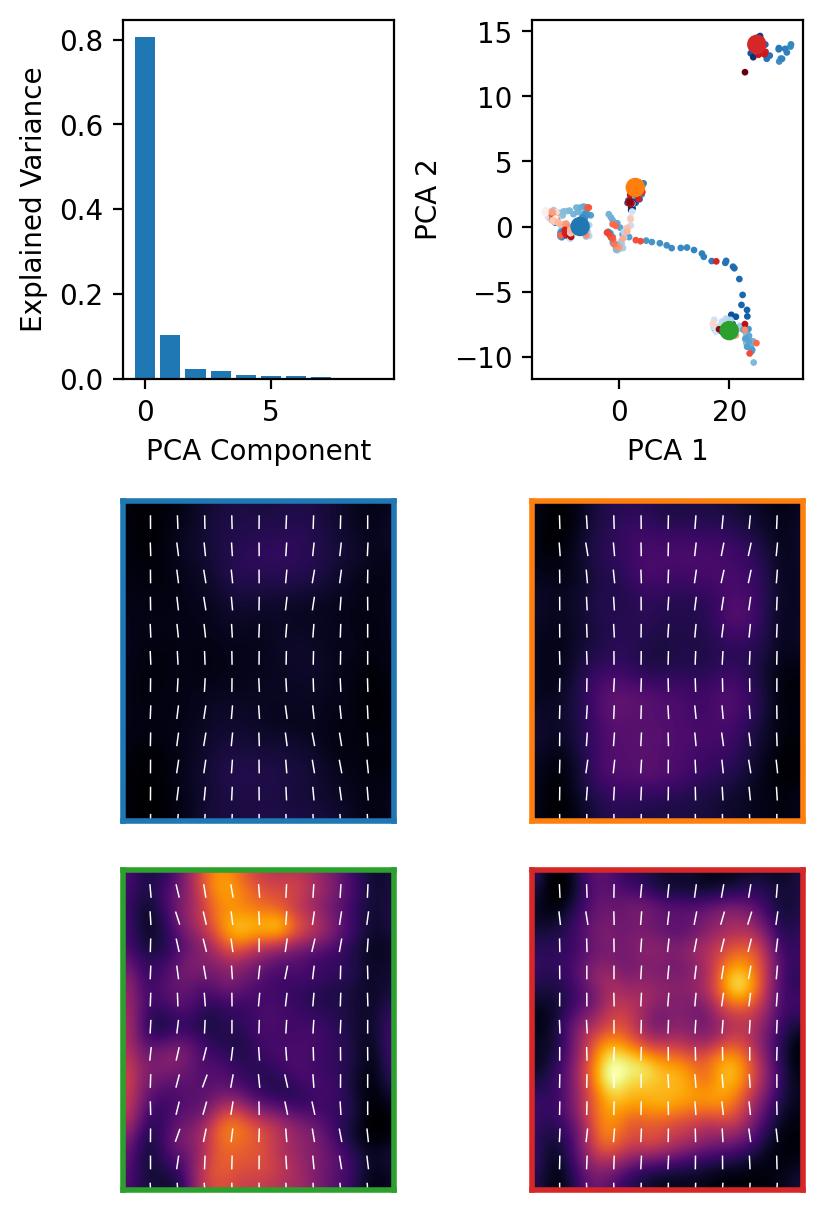

In [43]:
from sklearn.decomposition import PCA

n_components=10
pca = PCA(n_components=n_components)

pca_train = pca.fit_transform(y0_train.reshape([y0_train.shape[0], -1]))
pca_test = pca.transform(y0_test.reshape([y0_test.shape[0], -1]))

fig = plt.figure(figsize=(4, 6), dpi=200, constrained_layout=True)
gs = fig.add_gridspec(3, 4)

ax = fig.add_subplot(gs[0, :2])
ax.bar(np.arange(n_components), pca.explained_variance_ratio_)
ax.set(xlabel='PCA Component', ylabel='Explained Variance')

ax = fig.add_subplot(gs[0, 2:])
ax.scatter(pca_train[:, 0], pca_train[:, 1], c=train_df.time.values, cmap='Blues', s=2)
ax.scatter(pca_test[:, 0], pca_test[:, 1], c=test_df.time.values, cmap='Reds', s=2)
ax.set(xlabel='PCA 1', ylabel='PCA 2')


points = np.zeros([4, n_components])
points[:, :2] = np.array([[-7, 0], [3, 3], [20, -8], [25, 14]])

z = pca.inverse_transform(points).reshape([-1, 4, 236, 200])

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:points.shape[0]]
ax.scatter(points[:, 0], points[:, 1], color=colors)

axes = [
    fig.add_subplot(gs[1, :2]),
    fig.add_subplot(gs[1, 2:]),
    fig.add_subplot(gs[2, :2]),
    fig.add_subplot(gs[2, 2:])
]

vmax = np.max(np.linalg.norm(z, axis=1))

for i in range(len(points)):
    a = axes[i]
    plot_tensor2D(a, z[i], vmax=vmax)
    for spine in a.spines.values():
        spine.set_edgecolor(colors[i])
        spine.set_linewidth(2)
